In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

In [ ]:
def initialize_parameters_with_v(nx,nh1,nh2,ny):
    #set tensorflow global random seed
    tf.random.set_seed(1)

    #initialize weights to small random numbers and biases to zeros for each layer. Note that weights and biases are defined as tensorflow variables instead of numpy arrays
    W1=tf.Variable(tf.random.uniform(shape=(nh1,nx), minval=-0.01, maxval=0.01), name="W1")
    v_W1=tf.Variable(tf.zeros(shape=(nh1,nx),name="v_W1" ))
    b1=tf.Variable(tf.zeros(shape=(nh1,1),name="b1" ))
    v_b1=tf.Variable(tf.zeros(shape=(nh1,1),name="v_b1" ))
    W2=tf.Variable(tf.random.uniform(shape=(nh2,nh1), minval=-0.01, maxval=0.01), name="W2")
    v_W2=tf.Variable(tf.zeros(shape=(nh2,nh1),name="v_W2" ))
    b2=tf.Variable(tf.zeros(shape=(nh2,1),name="b2" ))
    v_b2=tf.Variable(tf.zeros(shape=(nh2,1),name="v_b2" ))
    W3=tf.Variable(tf.random.uniform(shape=(ny,nh2), minval=-0.01, maxval=0.01), name="W3")
    v_W3=tf.Variable(tf.zeros(shape=(ny,nh2),name="v_W3" ))
    b3=tf.Variable(tf.zeros(shape=(ny,1), name="b3"))
    v_b3=tf.Variable(tf.zeros(shape=(ny,1),name="v_b3" ))

    #create a dictionary of network parameters
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "v_W1": v_W1,
                  "v_b1": v_b1,
                  "v_W2": v_W2,
                  "v_b2": v_b2,
                  "v_W3": v_W3,
                  "v_b3": v_b3}

    return parameters

In [ ]:
def initialize_parameters(nx,nh1,nh2,ny):
    #set tensorflow global random seed
    tf.random.set_seed(1)

    #initialize weights to small random numbers and biases to zeros for each layer. Note that weights and biases are defined as tensorflow variables instead of numpy arrays
    W1=tf.Variable(tf.random.uniform(shape=(nh1,nx), minval=-0.01, maxval=0.01), name="W1")
    b1=tf.Variable(tf.zeros(shape=(nh1,1),name="b1" ))
    W2=tf.Variable(tf.random.uniform(shape=(nh2,nh1), minval=-0.01, maxval=0.01), name="W2")
    b2=tf.Variable(tf.zeros(shape=(nh2,1),name="b2" ))
    W3=tf.Variable(tf.random.uniform(shape=(ny,nh2), minval=-0.01, maxval=0.01), name="W3")
    b3=tf.Variable(tf.zeros(shape=(ny,1), name="b3"))

    #create a dictionary of network parameters
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return parameters

In [ ]:
def forward_pass(parameters,X):
    #the input image is read as an integer, use tf.cast to cast it to float before using it in fowrard pass computation.
    Z1= tf.matmul(parameters["W1"],X)+ parameters["b1"] # b1 is broadcasted n times before it is added to
    A1=tf.nn.relu(Z1)
    Z2=tf.matmul(parameters["W2"],A1)+parameters["b2"] #b2 is broadcasted n times before it is added to np.dpt(W2,A1)
    A2=tf.nn.relu(Z2)
    Z3=tf.matmul(parameters["W3"],A2)+parameters["b3"] #b3 is broadcasted n times before it is added to np.dpt(W3,A2)
    Yhat=tf.nn.softmax(Z3, axis=0)

    return Yhat

In [ ]:
def forward_pass_with_dropout(parameters,X,dropout_rate):

    prob = 1 - dropout_rate
    Z1= tf.matmul(parameters["W1"],X)+ parameters["b1"] # b1 is broadcasted n times before it is added to
    A1=tf.nn.relu(Z1)
    dropout_layer1 = tfp.distributions.Bernoulli(probs=prob, dtype=tf.float32).sample(A1.shape)
    A1 = tf.math.divide(A1, prob)
    A1 = tf.math.multiply(A1, dropout_layer1)
    Z2=tf.matmul(parameters["W2"],A1)+parameters["b2"] #b2 is broadcasted n times before it is added to np.dpt(W2,A1)
    A2=tf.nn.relu(Z2)
    dropout_layer2 = tfp.distributions.Bernoulli(probs=prob, dtype=tf.float32).sample(A2.shape)
    A2 = tf.math.divide(A2, prob)
    A2 = tf.math.multiply(A2, dropout_layer2)
    Z3=tf.matmul(parameters["W3"],A2)+parameters["b3"] #b3 is broadcasted n times before it is added to np.dpt(W3,A2)
    Yhat=tf.nn.softmax(Z3, axis=0)

    return Yhat


In [ ]:
def cross_entropy_loss(y_true, y_pred, epsilon=1e-12):
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    log_probs = tf.multiply(y_true, tf.math.log(y_pred))
    per_sample_loss = -tf.reduce_sum(log_probs, axis=0)
    average_loss = tf.reduce_mean(per_sample_loss)
    return average_loss

In [ ]:
def backward_pass(parameters, loss, tape):
    gradients= tape.gradient(loss,parameters)
    return gradients

In [ ]:
def update_parameters_with_nesterov(parameters, gradients, learning_rate, decay_rate):
    parameters["v_W1"].assign(decay_rate*parameters["v_W1"] - learning_rate*gradients["W1"])
    parameters["v_b1"].assign(decay_rate*parameters["v_b1"] - learning_rate*gradients["b1"])
    parameters["v_W2"].assign(decay_rate*parameters["v_W2"] - learning_rate*gradients["W2"])
    parameters["v_b2"].assign(decay_rate*parameters["v_b2"] - learning_rate*gradients["b2"])
    parameters["v_W3"].assign(decay_rate*parameters["v_W3"] - learning_rate*gradients["W3"])
    parameters["v_b3"].assign(decay_rate*parameters["v_b3"] - learning_rate*gradients["b3"])

    parameters["W1"].assign_add(decay_rate*parameters["v_W1"] - learning_rate*gradients["W1"])
    parameters["b1"].assign_add(parameters["v_b1"])
    parameters["W2"].assign_add(parameters["v_W2"])
    parameters["b2"].assign_add(parameters["v_b2"])
    parameters["W3"].assign_add(parameters["v_W3"])
    parameters["b3"].assign_add(parameters["v_b3"])


    return parameters

In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"].assign_sub(learning_rate*gradients["W1"])
    parameters["W2"].assign_sub(learning_rate*gradients["W2"])
    parameters["W3"].assign_sub(learning_rate*gradients["W3"])
    parameters["b1"].assign_sub(learning_rate*gradients["b1"])
    parameters["b2"].assign_sub(learning_rate*gradients["b2"])
    parameters["b3"].assign_sub(learning_rate*gradients["b3"])
    return parameters

In [ ]:
def create_nn_model(train_X,train_Y,nh1,nh2, val_X, val_Y, batch_size, num_iterations, learning_rate):
    """
    Do some safety check on the data before proceeding.
    train_X and val_X must have the same number of features (i.e., same number of rows)
    train_X must have the same number of examples as train_Y (i.e., same number of columns )
    val_X must have the same number of examples as Val_Y
    """
    assert(train_X.shape[0]==val_X.shape[0]), "train_X and val_X must have the same number of features"
    assert(train_X.shape[1]==train_Y.shape[1]), "train_X and train_Y must have the same number of examples"
    assert(val_X.shape[1]==val_Y.shape[1]), "val_X and val_Y must have the same number of examples"


    #getting the number of features
    nx=train_X.shape[0]

    # We want to use this network for binary classification, so we have only one neuron in the output layer with a sigmoid activation
    ny=10

    # initializing the parameteres
    parameters=initialize_parameters(nx,nh1,nh2,ny)


    #initialize lists to store the training and valideation losses.
    val_losses=[]
    train_losses=[]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_X.T, train_Y.T))
    train_dataset = train_dataset.batch(batch_size)

    #run num_iterations of gradient descent
    for i in range (0, num_iterations):

      """
        run forward pass and compute the loss function on training and validation data.
        Note that the forward pass and loss computations on the training data are enclosed inside the gradient tape context in order to build the computational graph.
        The gradients are only computed on the training data and used to update the parameter. Validation data is not used for training and updating the parameters.
        """
      batch_train_losses = []

      for batch in train_dataset:
        batch_X=batch[0].numpy().T
        batch_Y=batch[1].numpy().T

        with tf.GradientTape() as tape:
          #run the forward pass on train_X
          train_Yhat=forward_pass(parameters,batch_X)
          #compute the train_loss
          batch_train_loss=cross_entropy_loss(batch_Y,train_Yhat)

        #compute the gradients on the training data
        gradients=backward_pass(parameters,batch_train_loss,tape)

        # update the parameters
        parameters=update_parameters(parameters, gradients, learning_rate)

        batch_train_losses.append(batch_train_loss)

      train_loss=np.mean(batch_train_losses)



       #compute validation loss
      Yhat_val= forward_pass(parameters,val_X)
      val_loss=cross_entropy_loss(val_Y,Yhat_val)


      #print the trianing loss and validation loss for each iteration.
      print("iteration {} :train_loss:{} val_loss:{}".format(i,train_loss,val_loss))

       # append the train and validation loss for the current iteration to the train_losses and val_losses
      train_losses.append(train_loss)
      val_losses.append(val_loss)

      """
      Compute the gradients and update the parameters
      """



    #create a dictionary history and put train_loss and validaiton_loss in it
    history={"val_loss": val_losses,
             "train_loss": train_losses}


    #return the parameters and the history
    return parameters, history

In [ ]:
def create_nn_model_with_nesterov(train_X,train_Y,nh1,nh2, val_X, val_Y, batch_size, num_iterations, learning_rate):
    """
    Do some safety check on the data before proceeding.
    train_X and val_X must have the same number of features (i.e., same number of rows)
    train_X must have the same number of examples as train_Y (i.e., same number of columns )
    val_X must have the same number of examples as Val_Y
    """
    assert(train_X.shape[0]==val_X.shape[0]), "train_X and val_X must have the same number of features"
    assert(train_X.shape[1]==train_Y.shape[1]), "train_X and train_Y must have the same number of examples"
    assert(val_X.shape[1]==val_Y.shape[1]), "val_X and val_Y must have the same number of examples"


    #getting the number of features
    nx=train_X.shape[0]

    # We want to use this network for binary classification, so we have only one neuron in the output layer with a sigmoid activation
    ny=10

    # initializing the parameteres
    parameters=initialize_parameters_with_v(nx,nh1,nh2,ny)


    #initialize lists to store the training and valideation losses.
    val_losses=[]
    train_losses=[]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_X.T, train_Y.T))
    train_dataset = train_dataset.batch(batch_size)

    #run num_iterations of gradient descent
    for i in range (0, num_iterations):

      """
        run forward pass and compute the loss function on training and validation data.
        Note that the forward pass and loss computations on the training data are enclosed inside the gradient tape context in order to build the computational graph.
        The gradients are only computed on the training data and used to update the parameter. Validation data is not used for training and updating the parameters.
        """
      batch_train_losses = []

      for batch in train_dataset:
        batch_X=batch[0].numpy().T
        batch_Y=batch[1].numpy().T

        with tf.GradientTape() as tape:
          #run the forward pass on train_X
          train_Yhat=forward_pass(parameters,batch_X)
          #compute the train_loss
          batch_train_loss=cross_entropy_loss(batch_Y,train_Yhat)

        #compute the gradients on the training data
        gradients=backward_pass(parameters,batch_train_loss,tape)

        # update the parameters
        parameters=update_parameters_with_nesterov(parameters, gradients, learning_rate, 0.95)

        batch_train_losses.append(batch_train_loss)

      train_loss=np.mean(batch_train_losses)



       #compute validation loss
      Yhat_val= forward_pass(parameters,val_X)
      val_loss=cross_entropy_loss(val_Y,Yhat_val)


      #print the trianing loss and validation loss for each iteration.
      print("iteration {} :train_loss:{} val_loss:{}".format(i,train_loss,val_loss))

       # append the train and validation loss for the current iteration to the train_losses and val_losses
      train_losses.append(train_loss)
      val_losses.append(val_loss)

      """
      Compute the gradients and update the parameters
      """



    #create a dictionary history and put train_loss and validaiton_loss in it
    history={"val_loss": val_losses,
             "train_loss": train_losses}


    #return the parameters and the history
    return parameters, history

In [ ]:
def create_nn_model_with_nesterov_and_dropout(train_X,train_Y,nh1,nh2, val_X, val_Y, batch_size, num_iterations, learning_rate, dropout_rate):
    """
    Do some safety check on the data before proceeding.
    train_X and val_X must have the same number of features (i.e., same number of rows)
    train_X must have the same number of examples as train_Y (i.e., same number of columns )
    val_X must have the same number of examples as Val_Y
    """
    assert(train_X.shape[0]==val_X.shape[0]), "train_X and val_X must have the same number of features"
    assert(train_X.shape[1]==train_Y.shape[1]), "train_X and train_Y must have the same number of examples"
    assert(val_X.shape[1]==val_Y.shape[1]), "val_X and val_Y must have the same number of examples"


    #getting the number of features
    nx=train_X.shape[0]

    # We want to use this network for binary classification, so we have only one neuron in the output layer with a sigmoid activation
    ny=10

    # initializing the parameteres
    parameters=initialize_parameters_with_v(nx,nh1,nh2,ny)


    #initialize lists to store the training and valideation losses.
    val_losses=[]
    train_losses=[]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_X.T, train_Y.T))
    train_dataset = train_dataset.batch(batch_size)

    #run num_iterations of gradient descent
    for i in range (0, num_iterations):

      """
        run forward pass and compute the loss function on training and validation data.
        Note that the forward pass and loss computations on the training data are enclosed inside the gradient tape context in order to build the computational graph.
        The gradients are only computed on the training data and used to update the parameter. Validation data is not used for training and updating the parameters.
        """
      batch_train_losses = []

      for batch in train_dataset:
        batch_X=batch[0].numpy().T
        batch_Y=batch[1].numpy().T

        with tf.GradientTape() as tape:
          #run the forward pass on train_X
          train_Yhat=forward_pass_with_dropout(parameters,batch_X, dropout_rate)
          #compute the train_loss
          batch_train_loss=cross_entropy_loss(batch_Y,train_Yhat)

        #compute the gradients on the training data
        gradients=backward_pass(parameters,batch_train_loss,tape)

        # update the parameters
        parameters=update_parameters_with_nesterov(parameters, gradients, learning_rate, 0.95)

        batch_train_losses.append(batch_train_loss)

      train_loss=np.mean(batch_train_losses)



       #compute validation loss
      Yhat_val= forward_pass(parameters,val_X)
      val_loss=cross_entropy_loss(val_Y,Yhat_val)


      #print the trianing loss and validation loss for each iteration.
      print("iteration {} :train_loss:{} val_loss:{}".format(i,train_loss,val_loss))

       # append the train and validation loss for the current iteration to the train_losses and val_losses
      train_losses.append(train_loss)
      val_losses.append(val_loss)

      """
      Compute the gradients and update the parameters
      """



    #create a dictionary history and put train_loss and validaiton_loss in it
    history={"val_loss": val_losses,
             "train_loss": train_losses}


    #return the parameters and the history
    return parameters, history

In [ ]:
def predict(parameters,X):
    Yhat=forward_pass(parameters, X)
    predicted_labels = np.argmax(Yhat, axis=0)
    return predicted_labels

In [ ]:
def accuracy(observedY,predictedY):
    #return the ratio of the examples for which predictedY=observedY over the total number of examples
    return np.mean(predictedY==observedY)

In [ ]:
df=pd.read_csv("German_digits.csv").to_numpy()
print(df.shape)

(4426, 1601)


In [ ]:
X_digits = df[:, :-1]
Y_digits = df[:, -1]
X_digits = np.divide(X_digits, 255)
X_digits.shape, Y_digits.shape

((4426, 1600), (4426,))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_digits, Y_digits, test_size=0.2)
X_train = X_train.T
X_val = X_val.T
y_val_original = y_val
y_train = pd.get_dummies(y_train, dummy_na=False).to_numpy().T
y_val = pd.get_dummies(y_val, dummy_na=False).to_numpy().T
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1600, 3540), (1600, 886), (10, 3540), (10, 886))

In [ ]:
iterations=15
parameters, history=create_nn_model(X_train,y_train,256,256, X_val, y_val, 128, iterations, 0.3)

iteration 0 :train_loss:2.3024709224700928 val_loss:2.302746057510376
iteration 1 :train_loss:2.3003947734832764 val_loss:2.2999606132507324
iteration 2 :train_loss:2.2811126708984375 val_loss:2.2223093509674072
iteration 3 :train_loss:1.9710007905960083 val_loss:1.9168925285339355
iteration 4 :train_loss:1.4364817142486572 val_loss:2.671592950820923
iteration 5 :train_loss:1.097638726234436 val_loss:0.9219711422920227
iteration 6 :train_loss:0.7223386168479919 val_loss:0.6409105658531189
iteration 7 :train_loss:0.5181577801704407 val_loss:0.5620485544204712
iteration 8 :train_loss:0.41377440094947815 val_loss:0.4558841288089752
iteration 9 :train_loss:0.3222191631793976 val_loss:0.4357087016105652
iteration 10 :train_loss:0.23783114552497864 val_loss:0.4065873324871063
iteration 11 :train_loss:0.1872400939464569 val_loss:0.3965321481227875
iteration 12 :train_loss:0.15011033415794373 val_loss:0.38631436228752136
iteration 13 :train_loss:0.11582880467176437 val_loss:0.38573241233825684

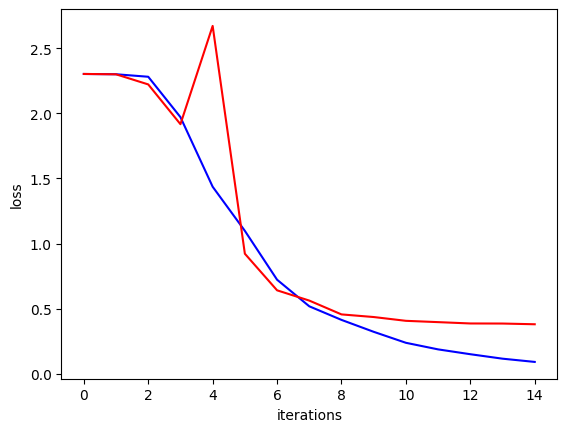

In [ ]:
plt.plot(range(0,iterations),history["train_loss"],'b')
plt.plot(range(0,iterations),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

In [ ]:
predicted_val=predict(parameters, X_val)
print("accurracy of the model on the test data is:", accuracy(y_val_original,predicted_val))

accurracy of the model on the test data is: 0.891647855530474


1. How do training and validation losses compare to the model without minibatch gradient
descent?

As done in the last assignment, model without mini batch but with same other parameters like no. of layers and no. of neurons in each layer, we got the below values

learning_rate = 0.3
iterations 500
train_loss:0.025572258979082108 val_loss:0.33255091309547424

With mini batch, with batch size of 128, model reached to lowest validation loss very quickly and then the val_loss started decreasing. Lowest val_loss in this case was bit higher as compared to previous case.

iterations = 15
train_loss:0.09093949943780899 val_loss:0.38018998503685

I tried with reducing the learning rate and increasing iterations but model did not reach above val_losses.




iteration 0 :train_loss:2.302579402923584 val_loss:2.3026790618896484
iteration 1 :train_loss:2.3016316890716553 val_loss:2.3029375076293945
iteration 2 :train_loss:2.300755739212036 val_loss:2.3027637004852295
iteration 3 :train_loss:2.2995123863220215 val_loss:2.3013503551483154
iteration 4 :train_loss:2.2965023517608643 val_loss:2.2966198921203613
iteration 5 :train_loss:2.286263942718506 val_loss:2.277571439743042
iteration 6 :train_loss:2.231069326400757 val_loss:2.1592652797698975
iteration 7 :train_loss:1.9386827945709229 val_loss:1.643584132194519
iteration 8 :train_loss:1.3494666814804077 val_loss:1.1354581117630005
iteration 9 :train_loss:1.0166046619415283 val_loss:0.9782320857048035
iteration 10 :train_loss:0.8448408842086792 val_loss:0.8280857801437378
iteration 11 :train_loss:0.7454439997673035 val_loss:0.7373965382575989
iteration 12 :train_loss:0.6163989901542664 val_loss:0.6477250456809998
iteration 13 :train_loss:0.5046483874320984 val_loss:0.5831068158149719
iteratio

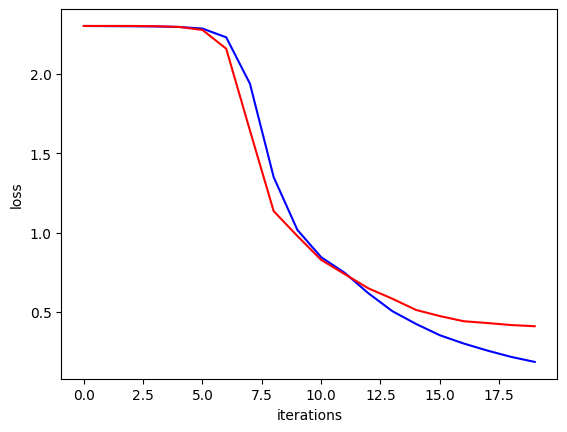

accurracy of the model on the test data is: 0.8803611738148984


In [ ]:
iterations=20
parameters, history=create_nn_model_with_nesterov(X_train,y_train,256,256, X_val, y_val, 128, iterations, 0.01)

plt.plot(range(0,iterations),history["train_loss"],'b')
plt.plot(range(0,iterations),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

predicted_val=predict(parameters, X_val)
print("accurracy of the model on the test data is:", accuracy(y_val_original,predicted_val))

2. Does Gradient Descent with Nesterov Momentum help improve your model ?

Initially I tried with learning rate as 0.3 as I did in the previous question, but that was too high for model nesterov momentum as it missed the lowest val_loss or local minima significantly before it started increasing.

So, I used learning rate as 0.01 and 20 iterations to reach the lowest val_loss

train_loss:0.18463613092899323 val_loss:0.4096124768257141

This val_loss is slightly higher with the model without nesterov but learning was smooth as seen in the curve. Also the gap between train_loss and val_loss decreased.

3. Reduce Learning Rate on Plateau

I have attached the screen capture for this question as a separate zip file with name plateau.zip.

best val_loss : 0.332
learning rate . 0.05
iteration with best lr : 13


iteration 0 :train_loss:2.3025145530700684 val_loss:2.3030078411102295
iteration 1 :train_loss:2.3017048835754395 val_loss:2.304089307785034
iteration 2 :train_loss:2.3009910583496094 val_loss:2.304637908935547
iteration 3 :train_loss:2.3000645637512207 val_loss:2.3040273189544678
iteration 4 :train_loss:2.2980926036834717 val_loss:2.3011088371276855
iteration 5 :train_loss:2.2921414375305176 val_loss:2.290442943572998
iteration 6 :train_loss:2.2669150829315186 val_loss:2.2341554164886475
iteration 7 :train_loss:2.1218883991241455 val_loss:1.9584414958953857
iteration 8 :train_loss:1.695642113685608 val_loss:1.3749427795410156
iteration 9 :train_loss:1.271422028541565 val_loss:1.0587722063064575
iteration 10 :train_loss:1.0774362087249756 val_loss:0.8980366587638855
iteration 11 :train_loss:0.9101681113243103 val_loss:0.78033447265625
iteration 12 :train_loss:0.7925428748130798 val_loss:0.6869695782661438
iteration 13 :train_loss:0.675482451915741 val_loss:0.6039668917655945
iteration 

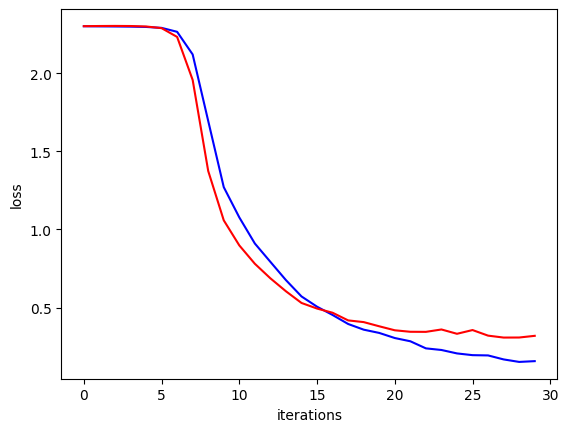

accurracy of the model on the test data is: 0.9029345372460497


In [ ]:
iterations=30
parameters, history=create_nn_model_with_nesterov_and_dropout(X_train,y_train,256,256, X_val, y_val, 128, iterations, 0.01, 0.5)

plt.plot(range(0,iterations),history["train_loss"],'b')
plt.plot(range(0,iterations),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

predicted_val=predict(parameters, X_val)
print("accurracy of the model on the test data is:", accuracy(y_val_original,predicted_val))

4. Does dropout regularization help reduce the gap between train and validation losses?

Dropout regularization decreased the gap between val and train loss significantly.

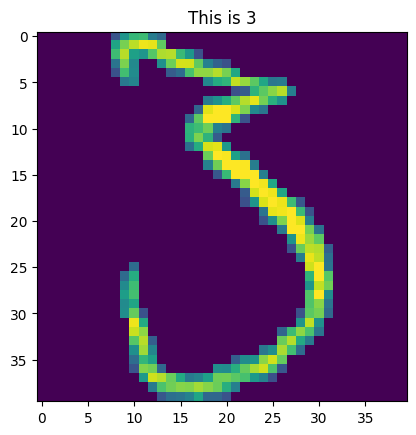

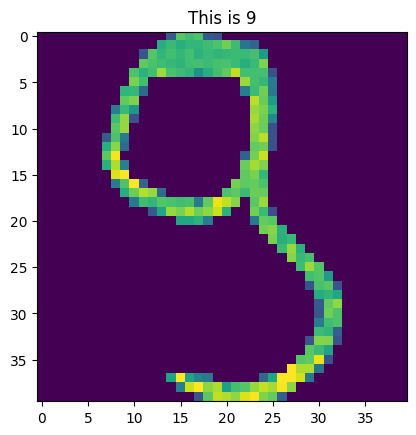

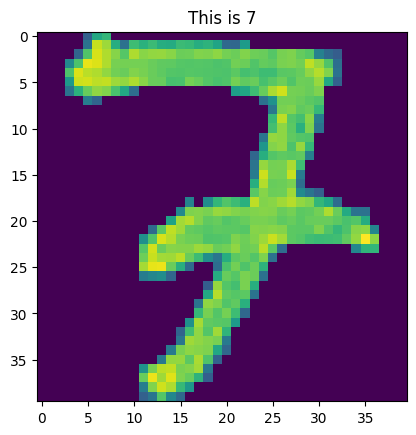

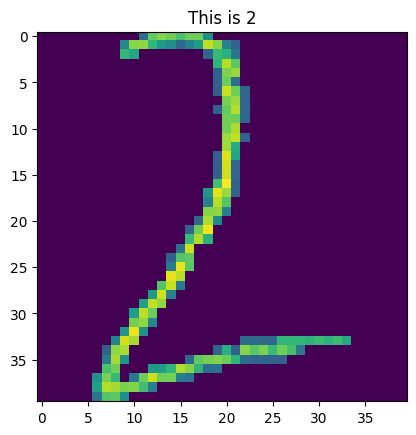

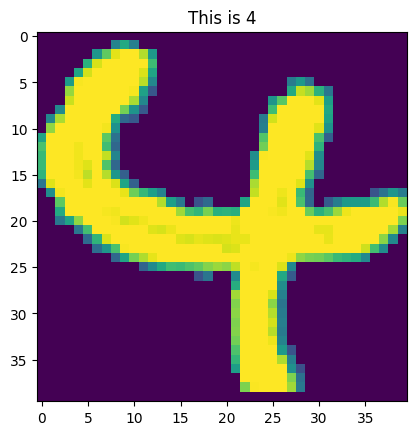

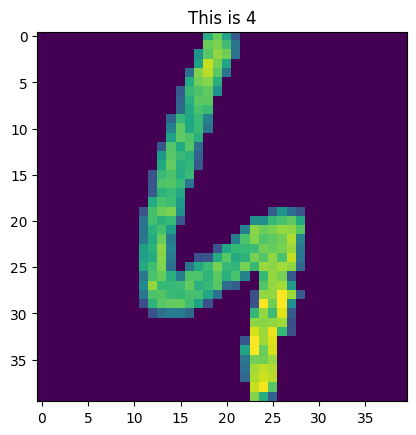

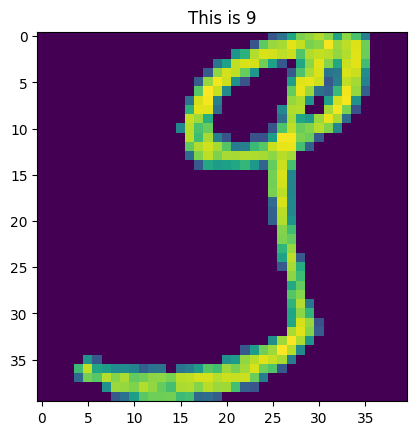

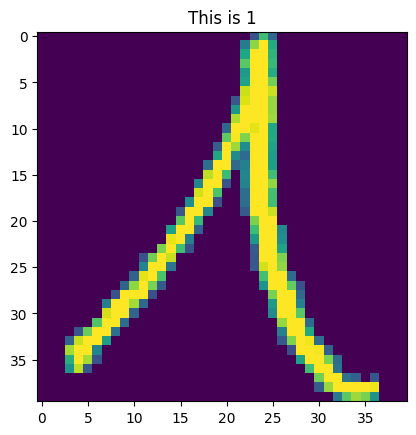

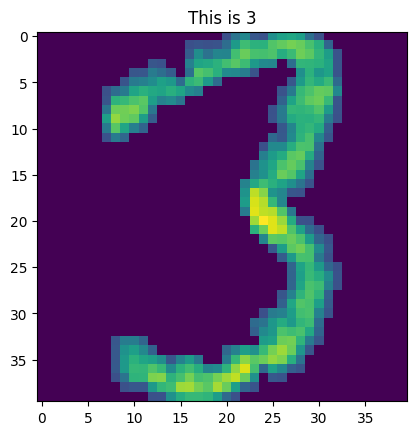

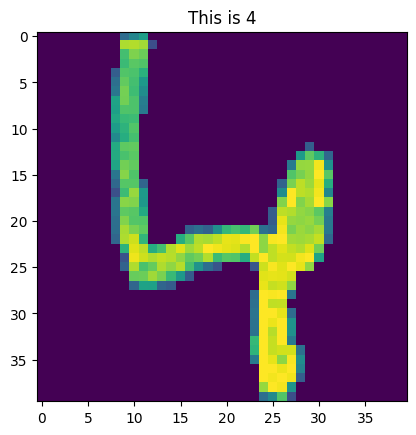

In [ ]:
X_val = np.multiply(X_val,255)

for i in range(10):
    image=X_val[:,i].reshape(40,40)
    plt.imshow(image)
    plt.title("This is {}".format(predicted_val[i]))
    plt.show()